<a href="https://colab.research.google.com/github/wxya2017/GR5242-CIFAR10/blob/master/wxy-model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir data

In [0]:
# !rm -rf logs
#  !rm -rf CNN

In [0]:
# Run Tensorflow in the background - note that we specify the log 
# directory we want to look at
LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [3]:
# Download and unzip ngrok - you will only need to do this once per session
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

--2018-11-28 06:10:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.174.228.92, 52.45.84.34, 52.54.84.112, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.174.228.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.51MB/s    in 1.5s    

2018-11-28 06:10:35 (3.51 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [4]:
# Launch the ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

# Get the public URL and be sorted!
! curl -s http://localhost:4040/api/tunnels | python3 -c\
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://dbd011f2.ngrok.io


In [5]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import tensorflow as tf

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def load_data(dir):
    train_x = np.array(unpickle(dir+'data_batch_1')[b'data'])
    train_y = np.array(unpickle(dir+'data_batch_1')[b'labels'])
    for i in range(2,6):
        train_x = np.concatenate((train_x, np.array(unpickle(dir+'data_batch_'+str(i))[b'data'])), axis = 0)
        train_y = np.concatenate((train_y, np.array(unpickle(dir+'data_batch_'+str(i))[b'labels'])),axis = 0)


    test_x = np.array(unpickle(dir+'test_batch')[b'data'])
    test_y = np.array(unpickle(dir+'test_batch')[b'labels'])   
    labels = unpickle(dir+'batches.meta')[b'label_names']
    return train_x, train_y, test_x, test_y, labels



/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# pre_process

In [0]:
def reshape(image):
    out = np.zeros(shape=[32,32,3])
    for i in range(3):
        out[:,:,i] = image[1024*i:1024*(i+1)].reshape([32,32])
    return out

def pre_process_x(x):
    new_x = np.zeros(shape=[len(x),32,32,3])
    for i in range(len(x)):
        new_x[i] = reshape(x[i])
    new_x = new_x/255
    return new_x

def pre_process_y(y):
    new_y = np.zeros([len(y),10])
    for i in range(len(y)):
        new_y[i][y[i]-1] = 1
    return new_y

def advance_pre_process(image):
#     image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    
    return image

def advance_pre_process_all(x):
    processed_x = tf.map_fn(lambda image: advance_pre_process(image), x)  
    return processed_x

In [7]:
ori_train_x, ori_train_y, ori_test_x, ori_test_y, labels = load_data('')

train_x = pre_process_x(ori_train_x)
test_x = pre_process_x(ori_test_x)
train_y = pre_process_y(ori_train_y)
test_y = pre_process_y(ori_test_y)
print("===>training data shape is "+ str(train_x.shape))
print("===>test data shape is "+ str(test_x.shape))
print("===>training label shape is "+ str(train_y.shape))
print("===>test label shape is "+ str(test_y.shape))

===>training data shape is (50000, 32, 32, 3)
===>test data shape is (10000, 32, 32, 3)
===>training label shape is (50000, 10)
===>test label shape is (10000, 10)


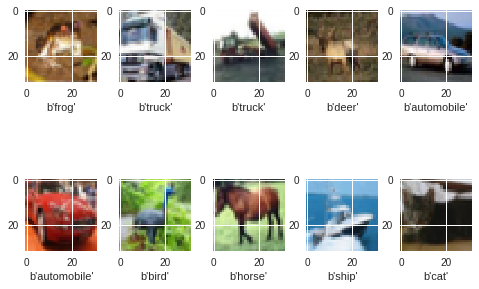

In [8]:
fig, axes = plt.subplots(2, 5)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
    # Plot image and smooth it
    ax.imshow(train_x[i])
    label = labels[ori_train_y[i]]
    ax.set_xlabel(label)

In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

# model

In [0]:
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def norm(x): 
    """simple wrapper for tf.nn.lrn... See section 3.3 of Krizhevsky 2012 for details"""
    return tf.nn.lrn(x, depth_radius=5, bias=2, alpha=1e-4, beta=0.75)

def dropout(x,pkeep):
    """simple dropout a fraction of parameter with keep_prob = pkeep"""
    return tf.nn.dropout(x, keep_prob=pkeep)

# evaluate performance on some data 
def perf_eval(logit_pred, y_true):
    """a function to evaluate performance of predicted y values vs true class labels"""
    # now look at some data
#     print('    sample pred: {0}\n    sample true: {1}'.format(np.argmax(logit_pred[0:20],1),np.argmax(y_true[0:20],1)))
    # avg accuracy
    is_correct_vals = np.equal(np.argmax(logit_pred,1),np.argmax(y_true,1))
    #accuracy_vals = np.mean(is_correct_vals)
    #print('    mean classification accuracy: {0}%'.format(100*accuracy_vals))
    # Dig in a little deeper.  Where did we make correct predictions?  Does this seem reasonable?
#     print('    correct predictions by class: {0}'.format(y_true[is_correct_vals,:].sum(axis=0)))

In [0]:
def compute_logits(x_new, x_ori, model_type, pkeep, training):
    if training == True:
        x = x_new
    else:
        x = x_ori
        
    """Compute the logits of the model"""
    if model_type=='lr':
        W = tf.get_variable('W', shape=[32*32*3, 10])
        b = tf.get_variable('b', shape=[10])
        logits = tf.add(tf.matmul(x, W), b, name='logits_lr')
    elif model_type=='cnn_cnf':
        # try a 1 layer cnn with a normalization layer
        n1 = 80
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # norm layer 1
        h_norm1 = norm(h_conv1)
        # fc layer to logits
        h_flat = tf.reshape(h_norm1, [-1, 32*32*n1])
        W_fc1 = tf.get_variable('W_fc1', shape=[32*32*n1, 10])
        b_fc1 = tf.get_variable('b_fc1', shape=[10])
        logits = tf.add(tf.matmul(h_flat, W_fc1), b_fc1, name='logits_cnn_cnf')
    elif model_type=='cnn_cpncf':
        # try a 1 layer cnn
        n1 = 64
        n2 = 64
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[3, 3, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # pool 1
        h_pool1 = maxpool(h_conv1)
        # norm layer 1
        h_norm1 = norm(h_pool1)
        # cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
        b_conv2 = tf.get_variable('b_conv2', shape=[n2])
        h_conv2 = tf.nn.relu(tf.add(conv(h_norm1, W_conv2), b_conv2))
        # fc layer to logits
        h_conv2_flat = tf.reshape(h_conv2, [-1, 16*16*n2])
        W_fc1 = tf.get_variable('W_fc1', shape=[16*16*n2, 10])
        b_fc1 = tf.get_variable('b_fc1', shape=[10])
        logits = tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1, name='logits_cnn_cpncf')
    elif model_type=='cnn_cpdcff':
        # try a 1 layer cnn
        n1 = 64
        n2 = 64
        n3 = 128
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[3, 3, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # pool 1
        h_pool1 = maxpool(h_conv1)
        # droupout 1
        h_drop1 = dropout(h_pool1,pkeep)
        # cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
        b_conv2 = tf.get_variable('b_conv2', shape=[n2])
        h_conv2 = tf.nn.relu(tf.add(conv(h_drop1, W_conv2), b_conv2))
        # fc layer 1
        h_conv2_flat = tf.reshape(h_conv2, [-1, 16*16*n2])
        W_fc1 = tf.get_variable('W_fc1', shape=[16*16*n2, n3])
        b_fc1 = tf.get_variable('b_fc1', shape=[n3])
        h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1))
        # fc layer 2 to logits
        W_fc2 = tf.get_variable('W_fc2', shape=[n3, 10])
        b_fc2 = tf.get_variable('b_fc2', shape=[10])
        logits = tf.add(tf.matmul(h_fc1, W_fc2), b_fc2, name='logits_cnn_cpdcff')
    elif model_type=='cnn_cpncpnff':
        # 2 layer cnn
        n1 = 64
        n2 = 64
        n3 = 1024
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # pool 1
        h_pool1 = maxpool(h_conv1)
        # norm 1
        h_norm1 = norm(h_pool1)
        # cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
        b_conv2 = tf.get_variable('b_conv2', shape=[n2])
        h_conv2 = tf.nn.relu(tf.add(conv(h_norm1, W_conv2), b_conv2))
        # pool 2
        h_pool2 = maxpool(h_conv2)
        # norm 2
        h_norm2 = norm(h_pool2)
        # fc layer to logits (8x8 since 2 rounds of maxpool)
        h_norm2_flat = tf.reshape(h_norm2, [-1, 8*8*n2])
        W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, n3])
        b_fc1 = tf.get_variable('b_fc1', shape=[n3])
        h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_norm2_flat, W_fc1), b_fc1))
        # one more fc layer
        # ... again, this is the logistic layer with softmax readout
        W_fc2 = tf.get_variable('W_fc2', shape=[n3,10])
        b_fc2 = tf.get_variable('b_fc2', shape=[10])
        logits = tf.add(tf.matmul(h_fc1, W_fc2), b_fc2, name='logits_cnn_cpncpnff')
    else: 
        print('error not a valid model type')

    return logits, h_conv1

def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    numerical_instability_example = 0
    if numerical_instability_example:
        y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.
        cross_ent = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    else:
        sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
        cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

In [0]:
# choose case to run 
opt_method = 'adam'
model_type = 'cnn_cpdcff' 
dir_name = 'logs/{}_{}'.format(model_type, opt_method)
batch_size = 128
train_size = 50000
starter_learning_rate = 1e-4

In [0]:
builder = tf.saved_model.builder.SavedModelBuilder('./CNN/savedmodel/'+ model_type+'/')
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32,32,3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    pkeep = tf.placeholder(tf.float32, name='pkeep')
    training = tf.placeholder(tf.bool, name='training')
    global_step = tf.train.get_or_create_global_step()
    
    
    x_ori = tf.reshape(x, [-1, 32*32*3])
    x_new = advance_pre_process_all(x = x)
    x_new = tf.reshape(x_new, [-1, 32*32*3])
    
    with tf.name_scope('model'):
        logits, h_conv1 = compute_logits(x_new, x_ori, model_type, pkeep, training)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)                                  
        

    with tf.name_scope('opt'):
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   train_size, 0.95, staircase=True)
        if opt_method == 'sgd':
            opt = tf.train.GradientDescentOptimizer(0.5)
        elif opt_method == 'rms':
            opt = tf.train.RMSPropOptimizer(.001)
        elif opt_method == 'adam':
            opt = tf.train.AdamOptimizer(learning_rate)
        train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
        # create summary for logits
        tf.summary.histogram('logits', logits)
        # create summary for image
        tf.summary.image('ori_image', tf.reshape(x_ori, [-1, 32, 32, 3])) 
        tf.summary.image('processed_image', tf.reshape(x_new, [-1, 32, 32, 3])) 
        
        summary_op = tf.summary.merge_all()
        
     
    saver = tf.train.Saver()
    print('------------- Training start! -------------------')
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/'+model_type+'/')
            pre_iteration = int(last_chk_path.split('.')[1].split('_')[-1])
            print(pre_iteration)
            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess.run(tf.global_variables_initializer())
            pre_iteration = 0
            
#         sess.run(tf.global_variables_initializer())
    
        for i in range(pre_iteration, train_size):
            batch = np.random.choice(40000, size = batch_size)
            X_batch = train_x[batch]
            y_batch = train_y[batch]
            global_step.assign(i)
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                    feed_dict={x: X_batch, y: y_batch, pkeep:0.4, training:True})
            # write the summary output to file

            if i%1000 == 0:
                summary_writer_train.add_summary(summary, i)
                
            # print diagnostics
            if i%1000 == 0:
                X_train_batch = train_x[0:batch_size,]
                y_train_batch = train_y[0:batch_size]
                (train_accu,train_logits) = sess.run((accuracy,logits), {x: X_train_batch, y: y_train_batch, pkeep:1.0, training:False})
                # further diagnostics
                perf_eval(train_logits, y_batch)
                X_valid_batch = valid_x
                y_valid_batch = valid_y
                (val_accu, summary) = sess.run((accuracy,summary_op), {x:X_valid_batch, y:y_valid_batch, pkeep:1.0, training:False})
                
                print("Step  " + str(i) + ": training accuracy " + str(train_accu) + "  val accuracy "+str(val_accu) )
                
                                
            if i%1000 == 0:
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './CNN/'+model_type+'/model_iter', global_step=i)
        save_name = './CNN/'+model_type+'/final_model_' + str(i) + '.ckpt'
        save_path = saver.save(sess, save_name)
        builder.add_meta_graph_and_variables(sess, ["foo-tag"])
                
        print('------------- Training done! -------------------')
        print('---------- Loading testing data ----------------')
        X_test_batch = test_x
        y_test_batch = test_y
        print('----------- Evaluating on testing --------------')
        (test_error) = sess.run(accuracy,{x:X_test_batch, y:y_test_batch, pkeep:1.0, training:False})
        print("Test accuracy " + str(test_error), flush=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

------------- Training start! -------------------
Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
Step  0: training accuracy 0.125  val accuracy 0.0959
Step  1000: training accuracy 0.4921875  val accuracy 0.4786
Step  2000: training accuracy 0.5546875  val accuracy 0.5354
Step  3000: training accuracy 0.65625  val accuracy 0.5641
Step  4000: training accuracy 0.6875  val accuracy 0.5841


# load model

In [0]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None, 32,32,3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    pkeep = tf.placeholder(tf.float32, name='pkeep')
    training = tf.placeholder(tf.bool, name='training')
    global_step = tf.train.get_or_create_global_step()

    x_ori = tf.reshape(x, [-1, 32*32*3])
    x_new = advance_pre_process_all(x = x)
    x_new = tf.reshape(x_new, [-1, 32*32*3])
    
    with tf.name_scope('model'):
        logits, h_conv1 = compute_logits(x_new, x_ori, model_type, pkeep, training)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)                                  
        

    with tf.name_scope('opt'):
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   train_size, 0.95, staircase=True)
        if opt_method == 'sgd':
            opt = tf.train.GradientDescentOptimizer(0.5)
        elif opt_method == 'rms':
            opt = tf.train.RMSPropOptimizer(.001)
        elif opt_method == 'adam':
            opt = tf.train.AdamOptimizer(learning_rate)
        train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
        # create summary for logits
        tf.summary.histogram('logits', logits)
        # create summary for image
        tf.summary.image('ori_image', tf.reshape(x_ori, [-1, 32, 32, 3])) 
        tf.summary.image('processed_image', tf.reshape(x_new, [-1, 32, 32, 3])) 
        
        summary_op = tf.summary.merge_all()
   
    saver = tf.train.Saver()
    sess = tf.Session()
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/'+model_type+'/')
    saver.restore(sess, save_path=last_chk_path)
    
    batch = np.random.choice(40000, size = batch_size)
    X_batch = train_x[batch]
    y_batch = train_y[batch]
    (train_accu, train_logits) = sess.run((accuracy, logits), {x: X_train_batch, y: y_train_batch, pkeep:1.0, training:False})
    print("\r Training accuracy {0:0.4f}".format(train_accu), flush=True)
    
    X_test_batch = test_x
    y_test_batch = test_y
    (test_accu, test_logits) = sess.run((accuracy, logits), {x:X_test_batch, y:y_test_batch, pkeep:1.0, training:False})
    print("\r Test accuracy {0:0.4f}".format(test_accu), flush=True)


INFO:tensorflow:Restoring parameters from ./CNN/cnn_cpdcff/final_model_999.ckpt
 Training accuracy 0.4700
 Test accuracy 0.5071


In [0]:
h_conv1

<tf.Tensor 'model/Relu:0' shape=(?, 32, 32, 64) dtype=float32>

In [0]:
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="rainbow")

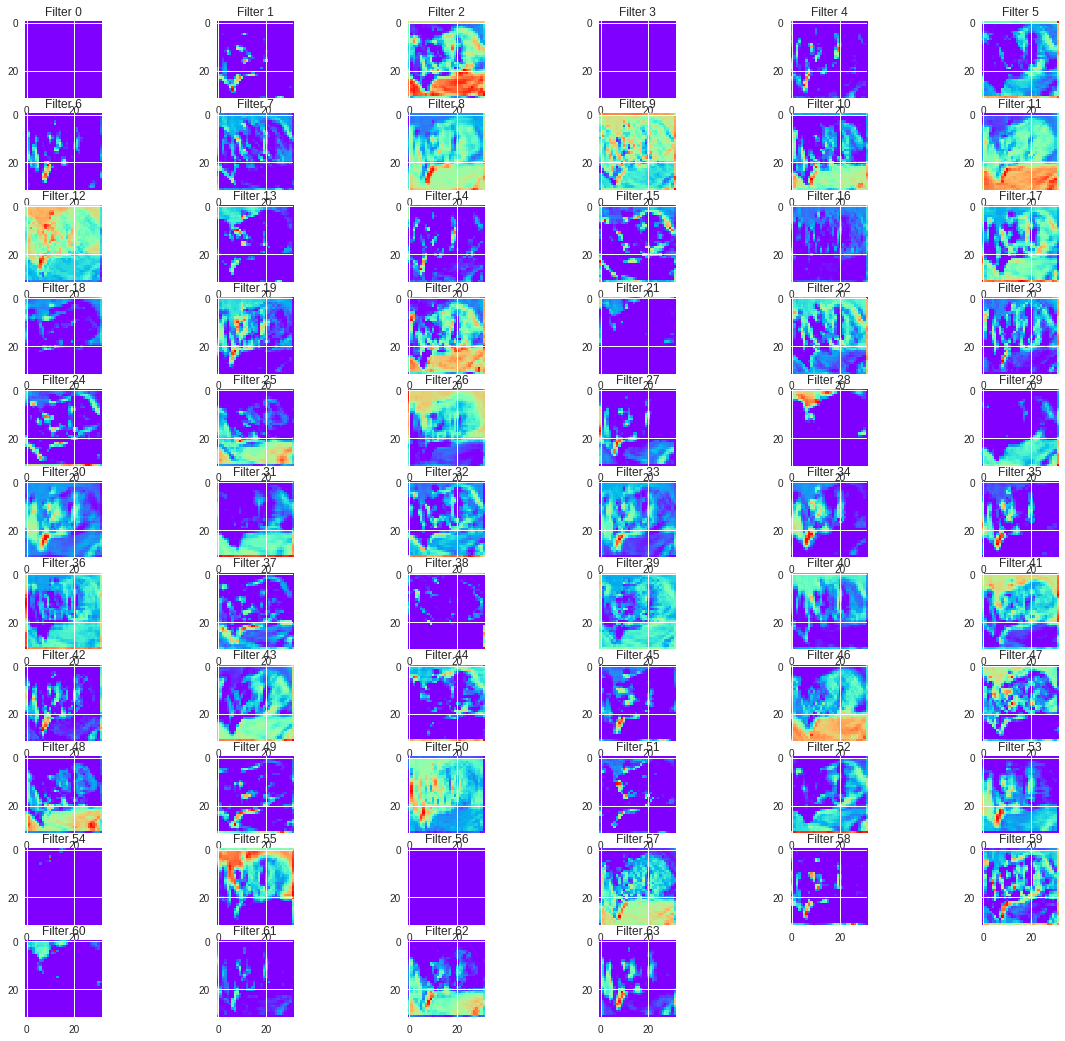

In [0]:
getActivations(sess,h_conv1,test_x)